In [1]:
## Import all necessary modules

import matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import os

from scipy.special import jv
from scipy.signal import savgol_filter

from Wavefront import Image, Telescope, TELESCOPE_DICT
from Wavefront import wavecorr, waveplot, utils, wavefft

pylab.rcParams['figure.figsize'] = 16, 12

main_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18'
data_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18/Data'
results_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18/Results'

/nfs/slac/g/ki/ki06/roodman/Software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
subdirectories = os.listdir(results_directory)
subdirectories.sort()

Z_noll = 5


fit_params = []
datafiles = []
r0s = []
vels = []

for subdirectory in subdirectories:
    if ("r0" in subdirectory) and ("v" in subdirectory):
        datapath = os.path.join(results_directory, subdirectory, 'Graphs', '{}_PSD_fit.csv'.format(subdirectory))
        try:
            datafile = os.path.basename(datapath)
            fit = np.loadtxt(datapath, dtype=np.float64, delimiter=',')
            fit_params.append(fit)
            datafiles.append(datafile)
            r0s.append(float(datafile.partition('r0')[2].partition('_')[0]))
            vels.append(float(datafile.partition('v')[2].partition('_')[0]))
        except IOError:
            print subdirectory
            pass
#zernike_coefficient_datapaths = [os.path.join(results_directory, subdirectory, '{}_coefficients.csv'.format(subdirectory))
#                                 for subdirectory in subdirectories if "r00" in subdirectory]

r0s = np.asarray(r0s)
vels = np.asarray(vels)
slopes = np.asarray([fit[0, Z_noll-1] for fit in fit_params])
intercepts = np.asarray([fit[1, Z_noll-1] for fit in fit_params])
amplitude = intercepts + slopes*22.37247

In [13]:
print r0s
print intercept

[ 0.11  0.11  0.11  0.11  0.11  0.11  0.11  0.11  0.11  0.11  0.12  0.12
  0.12  0.12  0.12  0.12  0.12  0.12  0.12  0.12  0.13  0.13  0.13  0.13
  0.13  0.13  0.13  0.13  0.13  0.13  0.14  0.14  0.14  0.14  0.14  0.14
  0.14  0.14  0.14  0.14  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.16
  0.16  0.16  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17
  0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.19  0.19
  0.19  0.19  0.19  0.19  0.19  0.19  0.19  0.19  0.1   0.1   0.1   0.1
  0.1   0.1   0.1   0.1   0.1   0.1   0.2   0.2   0.2   0.2   0.2   0.2
  0.2   0.2   0.2   0.2 ]
[-0.2428736  -0.23985741 -0.25079226 -0.23248058 -0.14241074 -0.10831882
 -0.07859198  0.00824931 -0.03320916 -0.05510405 -0.33173133 -0.30373414
 -0.24003421 -0.2287143  -0.24773079 -0.21483477 -0.19494213 -0.12492462
 -0.09030661 -0.12186085 -0.35259861 -0.37141622 -0.3770749  -0.27685782
 -0.26460174 -0.24048843 -0.2026679  -0.23269643 -0.17341837 -0.08705825
 -0.46632973 -0.37335805 -0

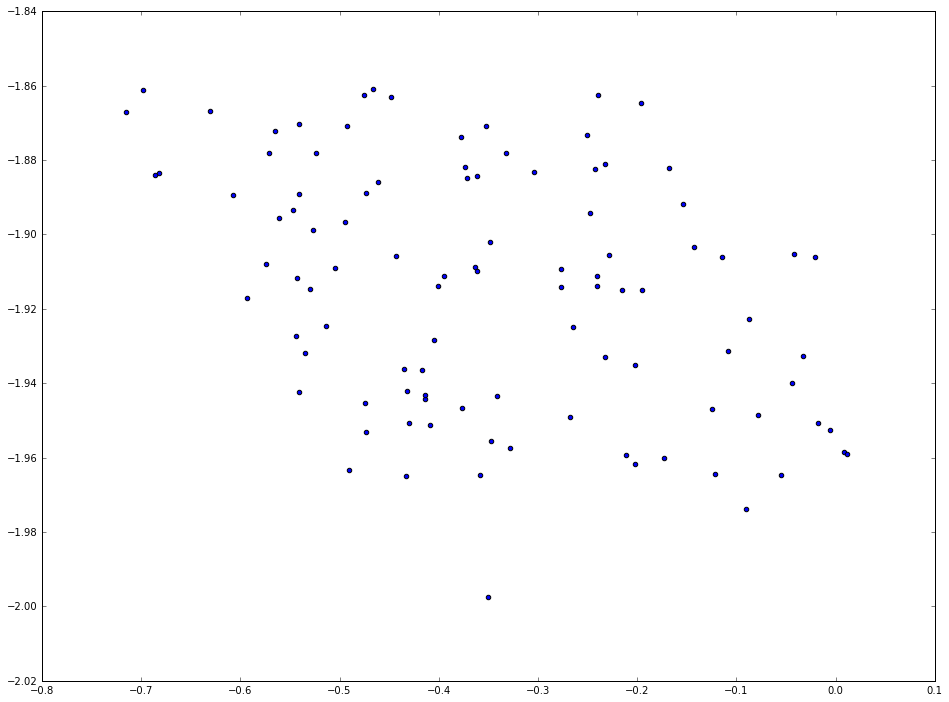

In [4]:
plt.scatter(intercepts, slopes)

In [3]:
PSD_r0_list = []
K_r0_list = []

for coefficients in coefficients_r0:
    
    PSD = np.zeros((37, coefficients.shape[0]//2+1), dtype=np.float64)

    for i in range(37):
    
        n = len(coefficients[:,i])
        fft_P = np.fft.rfft(coefficients[:,i])
        norm = 2.0/n
        
        PSD[i,:] = np.absolute(np.square(norm*fft_P))
    
    PSD_r0_list.append(PSD)
    K_r0_list.append(np.fft.rfftfreq(n, d=0.001))

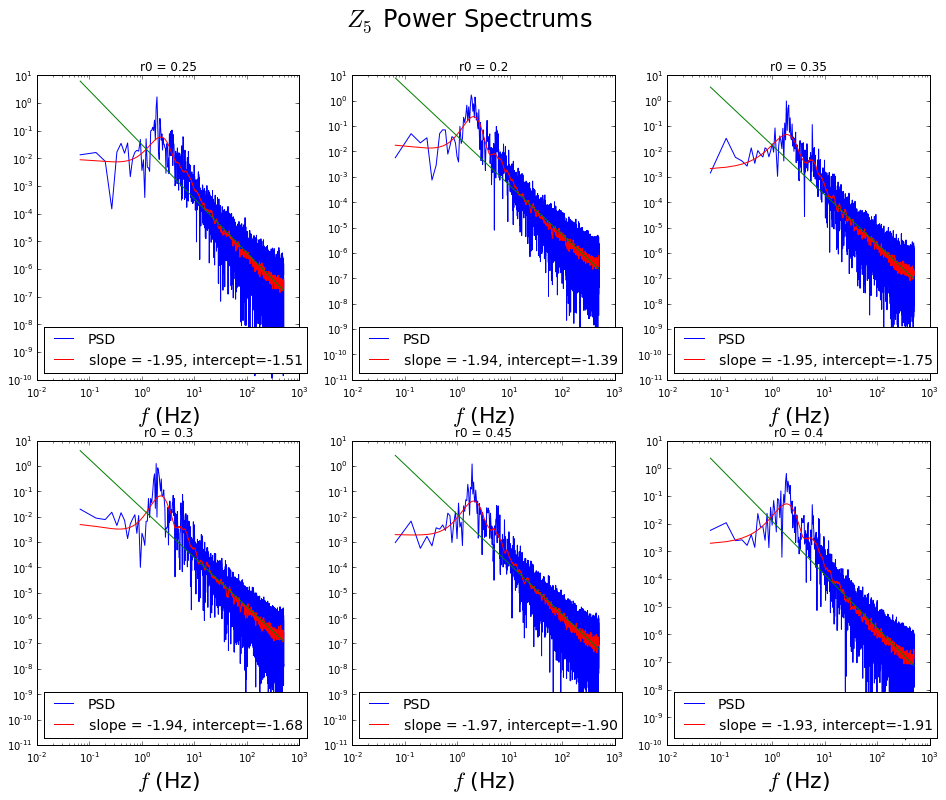

In [4]:
noll_Z = 5

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.suptitle(r'$Z_{}$ Power Spectrums'.format(noll_Z), fontsize=24)

for i, ax in enumerate(axes.flatten()):
    
    smoothed = 10**savgol_filter(np.log10(PSD_r0_list[i][noll_Z-1,:]), 101, 5)
    
    ## Perform linear fit to smoothed PSD
    par = np.polyfit(np.log10(K_r0_list[i][K_r0_list[i]>1.]), np.log10(smoothed[K_r0_list[i]>1.]), 1)
    slope = par[0]
    intercept = par[1]
    
    ## Plot original PSD, smoothed PSD, and linear fit
    img = ax.loglog(K_r0_list[i][1:], PSD_r0_list[i][noll_Z-1,1:], 'b',
                    K_r0_list[i][1:], smoothed[1:], 'r',
                    K_r0_list[i][1:], (10**intercept)*K_r0_list[i][1:]**slope, 'g')
    ax.legend(['PSD', 'slope = {0:.2f}, intercept={1:.2f}'.format(slope, intercept)], loc=3, fontsize=14)
    ax.set_title('r0 = {0}'.format(r0[i]))
#    img = ax.plot(np.log(K[1:]), slope*np.log(K[1:]) + intercept, 'g')
        
## Set axis labels for shared axis
for ax in axes.flatten():
    ax.set_xlabel(r'$f$ (Hz)', fontsize=22)
#axes[0].set_ylabel(r"$|\mathcal{{F}}(Z_{0})|^2$".format(noll_Z), fontsize=22)
plt.savefig('Z{}_psds.png'.format(noll_Z))

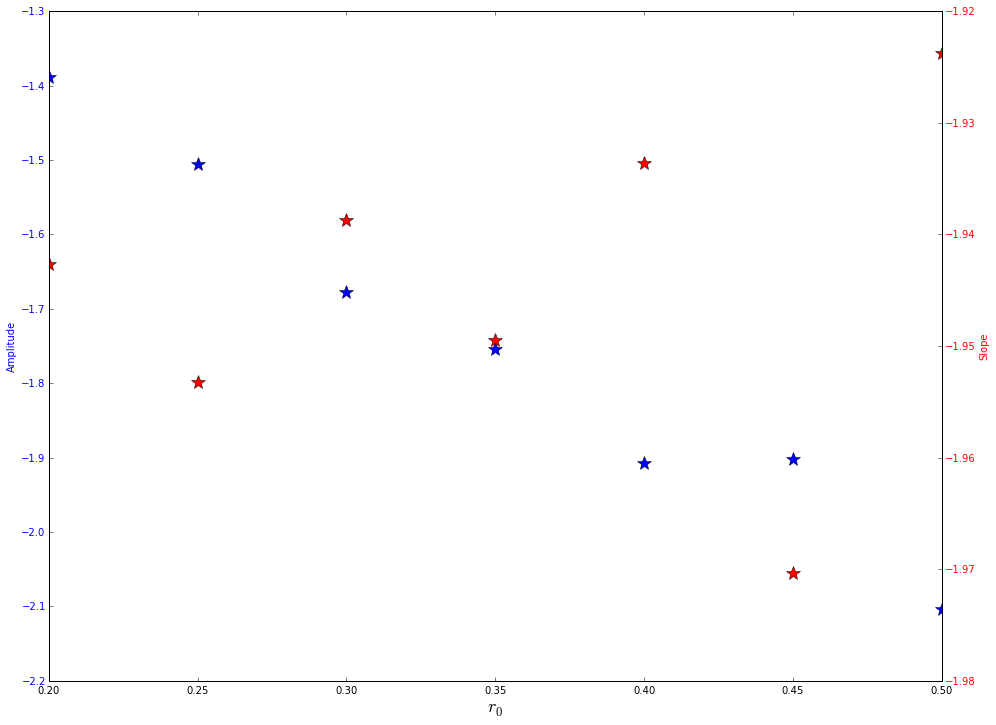

In [6]:
noll_Z = 5

slope = np.zeros(len(PSD_r0_list))
intercept = np.zeros(len(PSD_r0_list))


for i, PSD in enumerate(PSD_r0_list):
    
    smoothed = 10**savgol_filter(np.log10(PSD[noll_Z-1,:]), 101, 5)
    
    ## Perform linear fit to smoothed PSD
    par = np.polyfit(np.log10(K_r0_list[i][K_r0_list[i]>1.]), np.log10(smoothed[K_r0_list[i]>1.]), 1)
    slope[i] = par[0]
    intercept[i] = par[1]
    
fig, ax1 = plt.subplots()
ax1.plot(r0, intercept, 'b.', marker='*', markersize=14)
ax1.set_xlabel(r'$r_0$', fontsize=18)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Amplitude', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(r0, slope, 'r.', marker='*', markersize=14)
ax2.set_ylabel('Slope', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()

In [7]:
np.corrcoef(np.vstack((r0, intercept)))

array([[ 1.        , -0.98622765],
       [-0.98622765,  1.        ]])

In [8]:
np.corrcoef(np.vstack((r0, slope)))

array([[ 1.        ,  0.14021826],
       [ 0.14021826,  1.        ]])

In [9]:
PSD_v_list = []
K_v_list = []

for coefficients in coefficients_v:
    
    PSD = np.zeros((37, coefficients.shape[0]//2+1), dtype=np.float64)

    for i in range(37):
    
        n = len(coefficients[:,i])
        fft_P = np.fft.rfft(coefficients[:,i])
        norm = 2.0/n
        
        PSD[i,:] = np.absolute(np.square(norm*fft_P))
    
    PSD_v_list.append(PSD)
    K_v_list.append(np.fft.rfftfreq(n, d=0.001))

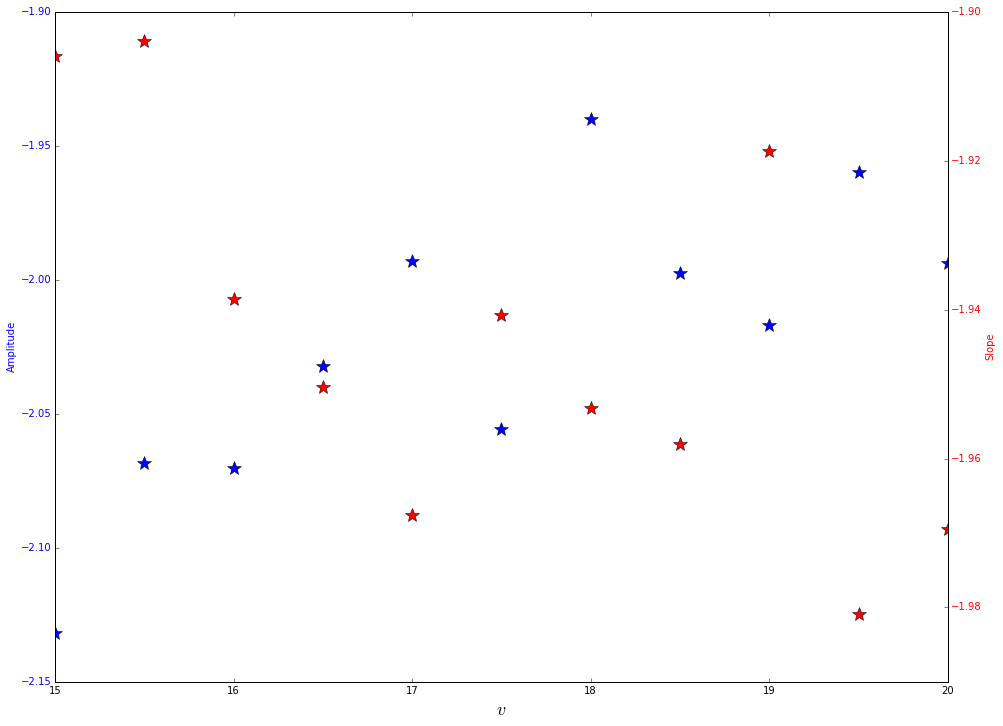

In [10]:
noll_Z = 5

slope = np.zeros(len(PSD_v_list))
intercept = np.zeros(len(PSD_v_list))


for i, PSD in enumerate(PSD_v_list):
    
    smoothed = 10**savgol_filter(np.log10(PSD[noll_Z-1,:]), 101, 5)
    
    ## Perform linear fit to smoothed PSD
    par = np.polyfit(np.log10(K_v_list[i][K_v_list[i]>1.]), np.log10(smoothed[K_v_list[i]>1.]), 1)
    slope[i] = par[0]
    intercept[i] = par[1]
    
fig, ax1 = plt.subplots()
ax1.plot(v, intercept, 'b.',marker='*', markersize=14)
ax1.set_xlabel(r'$v$', fontsize=18)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Amplitude', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(v, slope, 'r.', marker='*', markersize=14)
ax2.set_ylabel('Slope', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()

In [11]:
np.corrcoef(np.vstack((v, intercept)))

array([[ 1.        ,  0.76761239],
       [ 0.76761239,  1.        ]])

In [12]:
np.corrcoef(np.vstack((v, slope)))

array([[ 1.        , -0.66379601],
       [-0.66379601,  1.        ]])